#Efficient SAM Segment Everything Example

This script provides example for how to get segment everything visualization result from EfficientSAM using weight file.

The basic method is same as SAM, we generate a grid of point prompts over the image and get the masks. Currently we directly compute all the masks in one time so it requires a large memory. If you face OOM Issue, you can consider reduce the GRID_SIZE. We will update the efficient version by calculating the mask in local crops in the future.

the post processing part is from original SAM project to get a better visualization result, part of the visualization code are borrow from MobileSAM project, many thanks!

##Setup

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
import cv2
GRID_SIZE = 32

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tk0l_vy8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tk0l_vy8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


#Segment Everything Function

post processing script (borrow from SAM)

In [7]:
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)
from torchvision.ops.boxes import batched_nms, box_area
def process_small_region(rles):
        new_masks = []
        scores = []
        min_area = 100
        nms_thresh = 0.7
        for rle in rles:
            mask = rle_to_mask(rle[0])

            mask, changed = remove_small_regions(mask, min_area, mode="holes")
            unchanged = not changed
            mask, changed = remove_small_regions(mask, min_area, mode="islands")
            unchanged = unchanged and not changed

            new_masks.append(torch.as_tensor(mask).unsqueeze(0))
            # Give score=0 to changed masks and score=1 to unchanged masks
            # so NMS will prefer ones that didn't need postprocessing
            scores.append(float(unchanged))

        # Recalculate boxes and remove any new duplicates
        masks = torch.cat(new_masks, dim=0)
        boxes = batched_mask_to_box(masks)
        keep_by_nms = batched_nms(
            boxes.float(),
            torch.as_tensor(scores),
            torch.zeros_like(boxes[:, 0]),  # categories
            iou_threshold=nms_thresh,
        )

        # Only recalculate RLEs for masks that have changed
        for i_mask in keep_by_nms:
            if scores[i_mask] == 0.0:
                mask_torch = masks[i_mask].unsqueeze(0)
                rles[i_mask] = mask_to_rle_pytorch(mask_torch)
        masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
        return masks

In [8]:
def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
          predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
              img_tensor.cuda(),
              points.reshape(1, num_pts, 1, 2).cuda(),
              point_labels.reshape(1, num_pts, 1).cuda(),
              model.cuda(),
          )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)
    return predicted_masks

#Visualization Related

In [9]:
def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[ann] = color_mask
    ax.imshow(img)

#Create the model and load the weights from the checkpoint.

In [11]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

fatal: destination path 'EfficientSAM' already exists and is not an empty directory.


In [12]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import zipfile

with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()
efficient_sam_vits_model = efficient_sam_vits_model.to('cuda')


EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

## Segment Everything Example

prepare your own image here

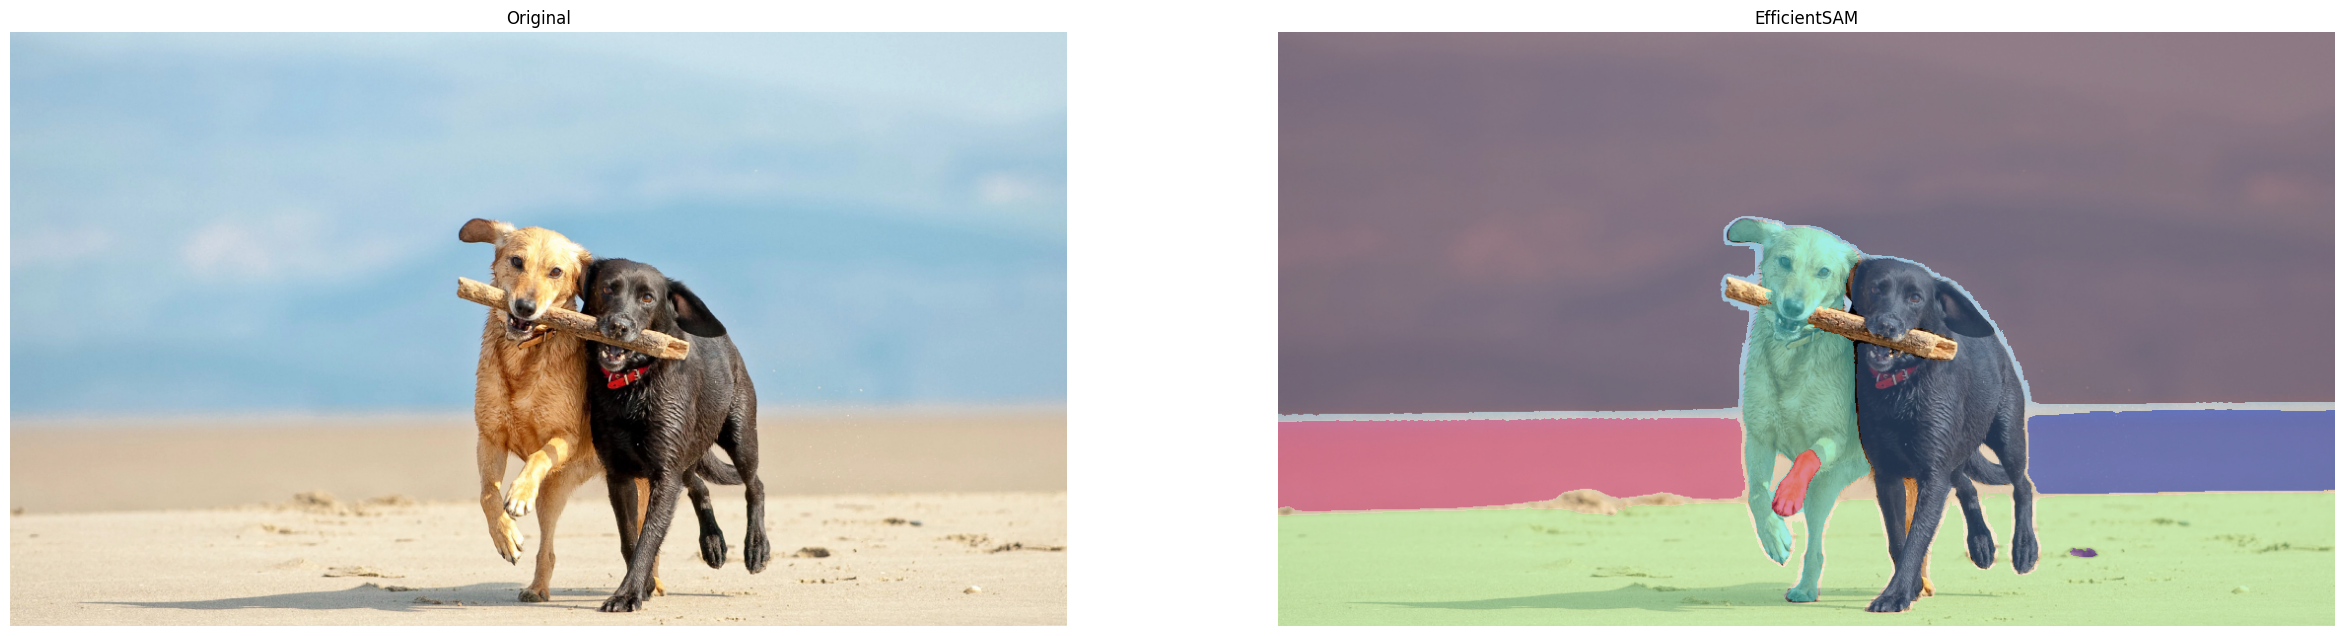

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
image_path = "figs/examples/dogs.jpg"
image = np.array(Image.open(image_path))
ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')

ax[1].imshow(image)
mask_efficient_sam_vits = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM")
ax[1].axis('off')


plt.show()